# <span style='color:#547DCD'> Import data and preamble  </span> 

Import packages. 

In [11]:
%run ../setup.py
import xgboost as xgb

from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

# <span style='color:#547DCD'> Validating and tuning  </span> 

There are several user choices to be made before training. E.g. parameter values or architectural choices (*see Probst, Bischl, and Boulesteix (2018) for a study on the impact of hyperparameter tuning on model performance*).

## <span style='color:#7F8BC7'> Learning metrics  </span> 

The parameter values that are set before training are called **hyperparameters**. For an econometric perspective see J. Li, Liao, and Quaedvlieg (2020). 

### <span style='color:#AA9AC2'> Regression analysis  </span> 

The $L^{1}$ and $L^{2}$ norms are the mainstream as they are easy to interpret and compute. The first one, the mean absolute error gives the average distance to the realized value but is not differentiable at zero. The second one is the root mean squared error, which is differentiable everywhere, but is harder to interpret and gives more weight to outliers. 
\begin{align*}
    \mathrm{MAE}(\mathbf{y},\tilde{\mathbf{y}}) & = \frac{1}{I} \sum_{i=1}^{I} \lvert y_i - \tilde{y}_i \rvert, \\
    \mathrm{MSE}(\mathbf{y}, \tilde{\mathbf{y}}) & = \frac{1}{I} \sum_{i=1}^{I}(y_i - \tilde{y}_i)^{2},
\end{align*}
and the RMSE is simply the square root of the MSE.

- We can add weights to produce heterogeneity in the importance of instances. 
- MSE is the most common loss function in ML, but not necessarily the best choice for return prediction in portfolio allocation tasks.
    - We can decompose loss into 3 terms: sum of squared realized returns, the sum of squared predicted returns and the product between the two (covariante terms if we assume zero mean).
        - First term: does not matter.
        - Second term: controls the dispersion around zero of the predictions.
        - Third term (most interesting): negativity of the cross-product is to the investor's benifit: either both terms are positive and the model has recognized a profitable asset, or they are negative and it has identified a bad opportunity. When $y_i$ and $\tilde{y}_i$ have different signs problems arise. Algorithms do not optimize with respect to this indicator.


Other indicators used to quantify the quality of a model are presented below:

The $R^{2}$ is computed like usual
$$
R^{2} (\mathbf{y}, \tilde{\mathbf{y}}) = 1 - \frac{\sum_{i=1}^{I}(y_i - \tilde{y}_i)^{2}}{\sum_{i=1}^{I}(y_i - \bar{y})^{2}}
$$
This can be used on the test and not train sample. Sometimes $\bar{y}$ is removed which means we compare with the zero mean predictor. This is relevant with returns because the simplest prediction of all is the constant zero value and $R^{2}$ can then measure if the model beats this naive benchmark. Sample averages can be period dependent. Also removing $\bar{y}$ makes $R^{2}$ more conservative by reducing it mechanically.

We can also use the mean absolute percentage error and mean squared percentage error:
\begin{gather*}
    \mathrm{MAPE}(\mathbf{y},\tilde{\mathbf{y}}) = \frac{1}{I} \sum_{i=1}^{I} \left\| \frac{y_i - \tilde{y}_i}{y_i} \right\|, \\
    \mathrm{MSPE}(\mathbf{y},\tilde{\mathbf{y}}) = \frac{1}{I} \sum_{i=1}^{I}\left( \frac{y_i-\tilde{y}_i}{y_i} \right) ^{2}
\end{gather*}

When the label is positive with possibly large values, it is possible to scale the magnitude of errors, which can be very large. One way to do this is to resort to the Root Mean Squared Logarithmic Error (RMSLE), defined below
$$
\mathrm{RMSLE}(\mathbf{y},\tilde{\mathbf{y}}) = \sqrt{\frac{1}{I}\sum_{i=1}^{I} \log\left( \frac{1+y_i}{1 + \tilde{y}_i} \right) }
$$

A shortcoming of the MSE, which is by far the most widespread metric and objective in regression tasks. A simple decomposition yields:
$$
\mathrm{MSE}(\mathbf{y},\tilde{\mathbf{y}}) = \frac{1}{I}\sum_{i=1}^{I}(y_i^{2}\tilde{y}_i^{2} - 2 y_i \tilde{y}_i)
$$
Since the first term is given, the model focuses on minimizing the latter terms. The second term is the dispersion of model values. The third term is a cross-product. While variations in $\tilde{y}_i$ do matter, the third term is by far the most important especially in the cross-section It is more valuable to reduce the MSE by increasing $y_i \tilde{y}_i$. This product is indeed positive when the two terms have the same sign, which is exactly what an investor is looking for: correct directions for the bets. For some algorithms (like neural networks), it is possible to manually specify custom losses. Maximizing the sum of $y_i \tilde{y}_i$ may be a good alternative to vanilla quadratic optimization.

### <span style='color:#AA9AC2'> Classification analysis  </span> 

In binary classification, it is convenient to think in terms of true versus false. In an investment setting, true can be related to a positive return, or a return being above that of a benchmark - false being the opposite.

We have the following types of outcomes:
- frequency of true positives: $\mathrm{TP} = I^{-1}\sum_{i=1}^{I} 1_{\{ y_i = \tilde{y}_i = 1 \}}$
- frequency of true negatives: $\mathrm{TP} = I^{-1}\sum_{i=1}^{I} 1_{\{ y_i = \tilde{y}_i = 0 \}}$
- frequency of false positives: $\mathrm{TP} = I^{-1}\sum_{i=1}^{I} 1_{\{ y_i = 0,  \tilde{y}_i = 1 \}}$
- frequency of false negatives: $\mathrm{TP} = I^{-1}\sum_{i=1}^{I} 1_{\{ y_i = 1, \tilde{y}_i = 0 \}}$

With these metrics we can calculate a confusion matrix. In the setting of investment we have the following:

|              | Positive | Negative |
|--------------|----------|----------|
| **Positive** |    TP    |   FP     |
| **Negative** |    FN    |   TN     |

Where the rows pertain to predictions and columns to label.

Among the two types of errors, type I is the most daunting for investors because it has a direct effect on the portfolio. The type II error is simply a missed opportunity and is somewhat less impactful. Finally, true negatives are those assets which are correctly excluded from the portfolio.

We can create the following metrics from this baseline:
- **Accuracy**: $\mathrm{TP} + \mathrm{TN}$ is the percentage of correct forecasts;
- **Recall**: $\frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$ measures the ability to detect a winning strategy/asset (left column analysis). Also known as sensitivity or true positive rate (TPR);
- **Precision**: $\frac{\mathrm{TP}}{\mathrm{FP} + \mathrm{TP}}$ computes the probability of good investments;
- **Specificity**: $\frac{\mathrm{TN}}{\mathrm{FP} + \mathrm{TN}}$ measures the proportion of actual negatives that are correctly identified as such;
- **Fallout**: $\frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$ $1-\text{Specificity}$ is the probability of false alarm (or false positive rate), i.e., the frequence at which the algorithm detects falsely performing assets;
- **F-score**: $\mathbf{F}_1 = 2 \times \frac{\text{recall} \times \text{precision}}{\text{recall} + \text{precision}}$ is the harmonic average of recall and precision.

All of these items lie in the unit interval and a model is deemed to perform better when they increase (except for fallout for which it is the opposite).

Another popular metric is the Area Under the (ROC) Curve, often referred to as AUC. The complicated part is the ROC curve where ROC stands for Receiver Operating Characteristic; the name comes from signal theory. We explain how it is built below.

Classifiers generate output that are probabilities that one instance belongs to one class. These probabilities are then translated into a class by choosing the class that has the highest value.

The idea of the ROC curve is to test what happens if the decision threshold changes. The ROC curve does just that and plots the recall as a function of the fallout when the threshold increases from zero to one.

An algorithm with a ROC curve above the 45° angle is performing better than an average classifier. Indeed, the curve can be seen as a tradeoff between benefits (probability of detecting good strategies on the axis) minus costs (odds of selecting the wrong assets on the axis). Hence being above the 45° is paramount. 

Below, we compute a ROC curve for a given set of predictions on the testing sample (however we do not have a model to use, since they do not provide one).

In [5]:
# roc_curve(testing_sample['R1M_Usd_C'].values, 
#           fit_RF_C.predict(testing_sample[features]))
# roc_auc = auc(fpr, tpr)
# display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
# display.plot() 
# plt.show()

The resulting curve is close to the $45^{\circ}$ meaning it it as good/bad as a random classifier. 

Having one entire curve is not practical for comparison purposes, hence the information of the whole curve is synthesized into the area below the curve. The $45^{\circ}$ angle (quadrant bisector) has an area of 0.5. Thus, any good model is expected to have an area under the curve (AUC) above 0.5. A perfect model has an AUC of one.

When we have multiclass data we *can* use these metrics, but they are not as good. We primarily use the cross-entropy. 

## <span style='color:#7F8BC7'> Validation  </span> 

Validation is the stage at which a model is tested and tuned before it starts to be deployed on real or live data.

### <span style='color:#AA9AC2'> The variance-bias tradeoff (theory)  </span> 

The variance-bias tradeoff is at the core of supervised learning.

Assume that data is generated by the simple model
$$
y_i = f(\mathbf{x}_i) + \epsilon_i, \quad \mathbb{E}[\boldsymbol{\epsilon}] = 0, \quad \mathbb{V}[\boldsymbol{\epsilon} ] = \sigma^{2}
$$
but the model that is estimated yields
$$
y_i = \hat{f}(\mathbf{x}_i) + \hat{\epsilon}_i
$$

Given an unknown $\mathbf{x}$ the decomposition of the average squared error is
\begin{gather*}
    \mathbb{E}[\hat{\epsilon}^{2}] = \mathbb{E}[(y-\hat{f}(\mathbf{x}))^{2}] = \mathbb{E}[(f(\mathbf{x}) + \epsilon - \hat{f}(\mathbf{x}))^{2}] \\
    = [\mathbb{E}[\hat{f}(\mathbf{x})]^{2} + \mathbb{E}[\hat{f}(\mathbf{x})]^{2}] + [\mathbb{E}[\hat{f}(\mathbf{x})]^{2} + f(\mathbf{x})^{2} - 2 f(\mathbf{x}) \mathbb{E}[\hat{f}(\mathbf{x})]] + \sigma^{2} \\
    = \mathbb{V}[\hat{f}(\mathbf{x})] + \mathbb{E}[(f(\mathbf{x}) - \hat{f}(\mathbf{x}))]^{2} + \sigma^{2}
\end{gather*}

The average squared error thus has three components:
- the variance of the model (over its predictions);
- the squared bias of the model;
- and one irreducible error (independent from the choice of a particular model).

The is an illustration of the variance-bias trade-off:
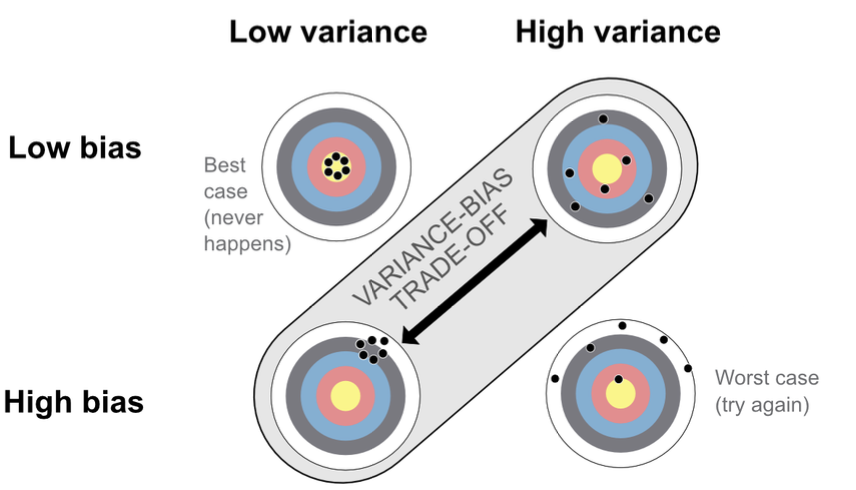

- The best case (top left) is when all shots are concentrated in the middle: on average, the archer aims correctly and all the arrows are very close to one another. 
- The worst case (bottom right) is the exact opposite: the average arrow is above the center of the target (the bias is nonzero) and the dispersion of arrows is large.
- The most often encountered cases in ML are the other two configurations: either the predictions are concentrated in a small perimeter, but the perimeter is not the center of the target; or the predictions are on average well distributed around the center, but they are, on average, far from it.


The second way the variance bias tradeoff is often depicted is via the notion of model complexity. 

- The most simple model of all is a constant one: the prediction is always the same, for instance equal to the average value of the label in the training set. Prediction far from the realized values of the testing set, but its variance is zero. 
- On the other side of the spectrum, a decision tree with as many leaves as there are instances has a very complex structure. It will probably have a smaller bias, but undoubtedly it is not obvious that this will compensate the increase in variance incurred by the intricacy of the model.

This facet of the tradeoff is depicted below. To the left of the graph, a simple model has a small variance but a large bias, while to the right it is the opposite for a complex model. Good models often lie somewhere in the middle, but the best mix is hard to find.

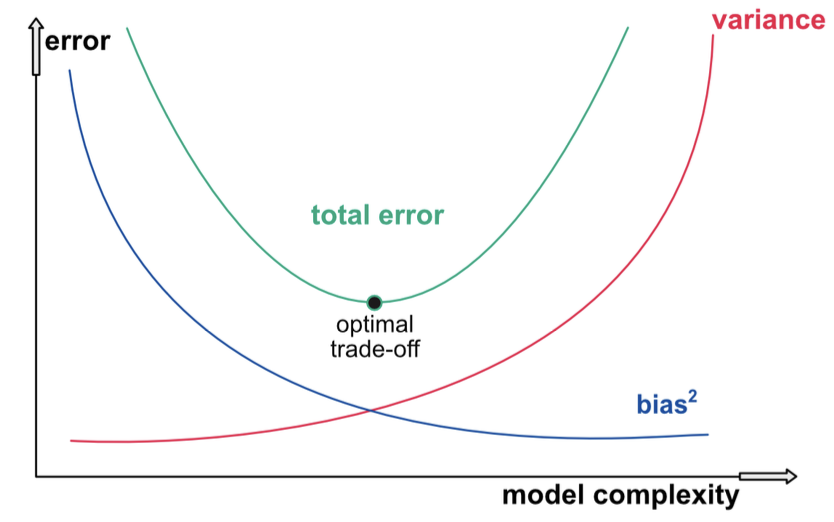

One simple example of bias-variance is ridge regression. See book for examples.

### <span style='color:#AA9AC2'> The risk of overfitting </span> 

#### <span style='color:#D4A8BC'> Principle  </span> 

- Reference for overfitting and impact thereof in portfolio strategies (does not touch on ML).
- The goal is to detect if learned patterns are spurious or not.
- Overfitted models perform poorly out of sample.

#### <span style='color:#D4A8BC'> Solutions  </span> 

**Agnostic solution**
- Easiest solution: resist making complicated models.
- Complexity if often proxied via: 1) amount of parameters and 2) their magnitude (synthesized trough their norm).
    - Not perfect proxies. E.g., some complex models only require few parameters and/or small parameter values.
- No universal way of handling overfitting.

**Regression**: Two approaches to handle overfitting
- *Number of parameters*: we can address overfitting by reducing number of parameters.
    - Only select subset of available features.
    - Especially useful if pairs of params are highly correlated ($> 0.7$).
- *Penalization*: we can introduce penalization into the regressions (LASSO, ridge, elasticnet).
    - Helps reduce magnitude of estimates and hereby reduce variance of predictions.

**Tree-based methods**:
- *Simple trees*: Reduce number of leaves. Can fx be done through
    - Impose max dept of tree: reduce number of final leaves by construction (recommended that $d>6$). 
    - Complexity parameter: any split must lead to meaningful reduction in loss.
    - Require each leaf has a minimum number of instances per cluster pre-split.
    - Require each leaf has a minimum number of instances in each leaf.
    
- *Random forests*: We can ease risk of overfitting via.
    - Reduce number of trees in forrest (in theory should not ease overfitting, just reduce total error via diversification).
    - Sub-sample size (on which learner is trained).
    - Number of features retained for learning.
    
- *Boosted trees*: Have more hyperparameters to be adjusted to ease risk of overfitting.
    - Learning rate: discounts the impact of each new tree by $\eta \in (0,1)$. 
        - When high, the algorithm learns too quickly and sticks close to the training data. 
        - When low the model learns very progressively; can be efficient if there are sufficiently many trees in the ensemble.
    - Learning rate and number of trees must be chosen synchronously:
        - if both low; ensemble will learn nothing.
        - if both large; it will overfit.
    - Penalizations: both of score values and of the number of leaves affect risk of overfitting.
    - Constraints on monotonicity; efficient way to impose some structure on the model. 
    
**Neural networks**
- Learning rate.
- Penalization of weights and biases (via their norm).
- Constraints (e.g, non-negativity).
- Dropout: direct way to reduce the dimension of network. 

## <span style='color:#7F8BC7'> Search for good hyperparameters </span> 

### <span style='color:#AA9AC2'> Methods  </span> 

Let $p$ be parameters defined before a model i run.

Two types of independent tests: **grid (deterministic)** and **random exploration**.

**Grid search**
- Pros: covers the space uniformly and makes sure that no corners are omitted. The 
- Cons: computation time; we need to test $5^{p}$ combinations if we define 5 possible values for each parameter.

**Random search**:
- Pros: User specifies a number of test upfront and parameters are drawn randomly (usually uniformly over a given range). Has been shown to be preferable to grid search.
- Cons: some areas in the parameter space may not be covered.

Both methods are suboptimal since they can search areas where the parameter space is irrelevant. We want to find the most likely area in the space for improvement. This is possible via an interative process that adapts the search after each new point has been tested (*see Lee (2020) and Nystrup, Lindstrom, and Madsen (2020)*).

**Bayesian optimizer**:

Has an object function, $O$, for the learning process; can be seen as a loss function with possible penalization and constraints. Here we assume test and training samples are assumed to be fixed. Variable of interest is $\mathbf{p}=(p_1, \ldots ,p_l)$ which synthesizes the hyperparameters (learning rate, penalization intensities, number of models, etc.) that have impact on $O$. We are interested in
$$
\mathbf{p}_{*} = \argmin_{\mathbf{p}} O(\mathbf{p})
$$
Main issue is computation of $O(\mathbf{p})$; choose $\mathbf{p}$ for each trial. We assume that $O$ is Gaussian and can be proxied by a linear combination of the $p_l$. Said differently, the aim is to build a Bayesian linear regression between the input $\mathbf{p}$ and the output (dependent variable) $\mathbf{O}$. Once a model has been estimated, the information that is concentrated in the posterior density of $\mathbf{O}$ is used to make an educated guess at where to look for new values of $\mathbf{p}$.

The guess is made based on a so-called **acquisition function**. Assume we have tested $m$ values for $\mathbf{p}$, called $\mathbf{p}^{(m)}$. The current best parameter is $\mathbf{p}_{m}^{*} = \argmin_{1\le k \le m} O(\mathbf{p}^{(k)})$. If we test point $\mathbf{p}$, then it will lead to an improvement only of $O(\mathbf{p}) < O(\mathbf{p}_{m}^{*})$. The average value of improvement is 
$$
\mathbf{EI}_m(\mathbf{p}) = \mathbb{E}_m [[O(\mathbf{p}_{m}^{*}) - O(\mathbf{p})]_{+}],
$$
where $[\cdot]_{+}$ emphasizes that when $O(\mathbf{p}) \ge O(\mathbf{p}_m^{*})$ the gain is zero. Expectation is indexed by $m$ since it is computed with respect to the posterior distribution of $O(\mathbf{p})$ based on the $m$ samples $\mathbf{p}^{(m)}$. The best choice for the next sample $\mathbf{p}^{(m)}$ is 
$$
\mathbf{p}^{m+1} = \argmin_{p} \mathrm{EI}_{m}(\mathbf{p}),
$$

which corresponds to the maximum location of the expected improvement. We can use other object functions, like the probability of improvement $\mathbb{P}_m[O(\mathbf{p}) < O(\mathbf{p}_{m}^{*})]$.

The process is:
- **step 1**: compute $O ( \mathbf{p}^{( m )} )$ for $m = 1 , \ldots  , M_0$ values of parameters. 
- **step 2a**: compute sequentially the posterior density of $O$ on all available points. 
- **step 2b**: compute the optimal new point to test $\mathbf{p}^{( m + 1 )}$ given in equation above.
- **step 2c**: compute the new objective value $O ( \mathbf{p}^{( m + 1 )} ) $. 
- **step 3**: repeat steps 2a to 2c as much as deemed reasonable and return the $\mathbf{p}^{(m)}$ that yields the smallest objective value.



### <span style='color:#AA9AC2'> Example of grid search  </span> 

Below we implement grid search. First we define the test data:

In [3]:
y_train = training_sample['R1M_Usd'].values # recall features/predictors, full sample
X_train = training_sample[features].values 

In [4]:
scorer = make_scorer(mean_absolute_error)
# A parameter grid for XGBoost
params = {
        'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], # Values for eta
        'n_estimators': [10, 50,100],         # Values for nrounds
        'reg_lambda': [0.01, 0.1, 1, 10, 100] # Values for lambda
        }

print(params)

{'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], 'n_estimators': [10, 50, 100], 'reg_lambda': [0.01, 0.1, 1, 10, 100]}


In [5]:
model = xgb.XGBRegressor(
    max_depth = 3, 
    n_jobs = -1,
    objective = 'reg:squarederror'
)

model_gs = GridSearchCV(
    model,
    param_grid = params,
    cv = 2,
    scoring = 'neg_mean_squared_error'
)


After having specified the model we train it below:

In [6]:
model_gs.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'n_estimators': [10, 50, 100],
                         'reg_lambda': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

The results of the grid search are shown below:

In [8]:
cv_results = pd.DataFrame(model_gs.cv_results_)
print(f'Best Parameters using grid search: {model_gs.best_params_}')

Best Parameters using grid search: {'learning_rate': 0.1, 'n_estimators': 10, 'reg_lambda': 100}


We can plot the mean squared errors below:

In [9]:
res_df = pd.DataFrame(cv_results,
                      columns = ["param_n_estimators","param_learning_rate","param_reg_lambda","mean_test_score"])
res_df['mean_test_score']=-res_df['mean_test_score'].values

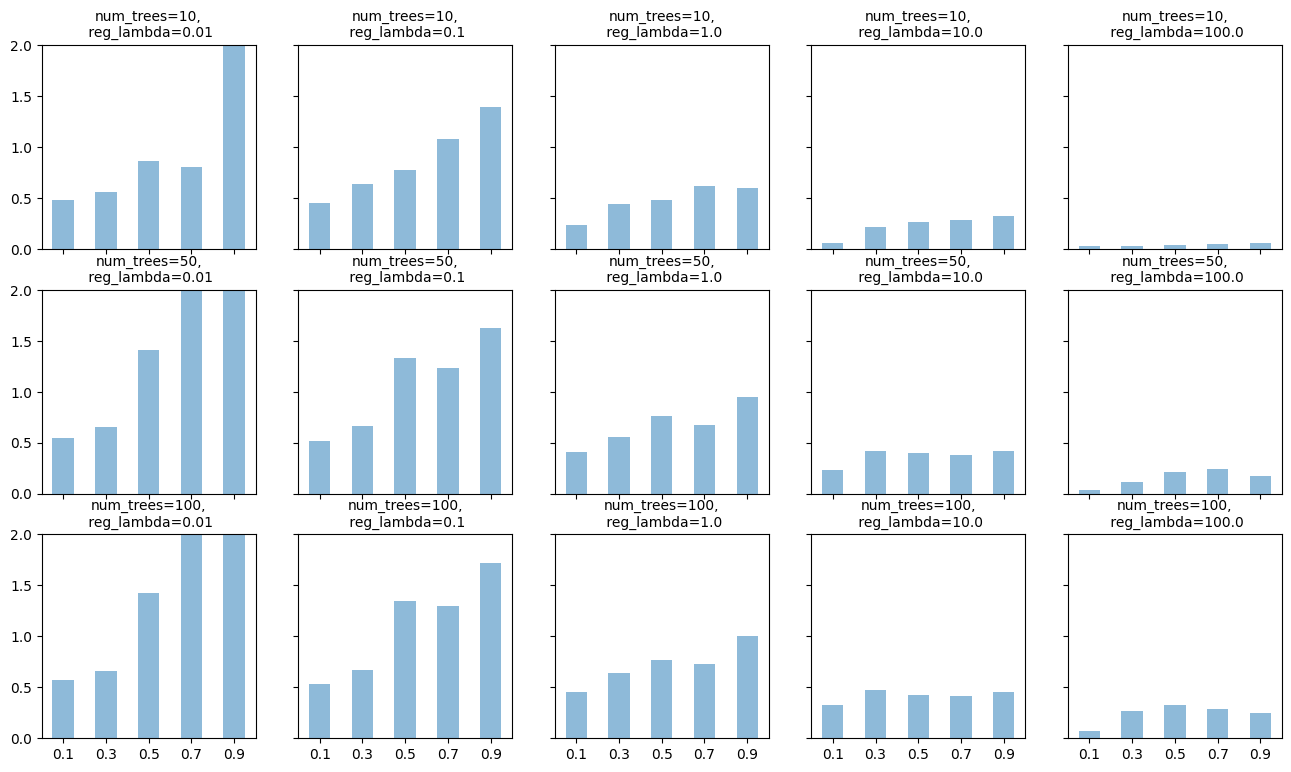

In [10]:
fig, axes = plt.subplots(figsize=(16, 9),nrows=3, ncols=5)
ax_all = plt.gca()
cnt = 0
for param, tmp in res_df.groupby(["param_n_estimators", "param_reg_lambda"]):
    ax = axes[cnt//5][cnt%5] # get the ax
    np.round(tmp[["param_learning_rate","mean_test_score"]],2).plot.bar(ax=ax, x="param_learning_rate", y="mean_test_score",
                                            alpha=0.5,legend=None)
    ax.set_xlabel("") # no xlabel
    ax.set_ylim(0, 2) # set y range
    # adjust xtick labels / adjust ytick labels
    if cnt//5 < 2:
        ax.xaxis.set_ticklabels("")
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(0);
    if cnt%5 > 0:
        ax.yaxis.set_ticklabels("")
    # set title
    ax.set_title(f"num_trees={param[0]},\n reg_lambda={param[1]}",fontsize=10);
    # update
    cnt =cnt+1

We can see that high learning rates are bad when the number of trees is small. Additionally, high learning rates are bad when `reg_lambda` is small. Models with more trees and higher `reg_lambda` seem to perform the best generally, but the best models are found when the learning rate is small, amount of trees small and penalization factor is high.

**Grid search can be performed in two stages: the first stage helps locate the zones that are of interest (with the lowest loss/objective values) and then zoom in on these zones with refined values for the parameter on the grid**.

### <span style='color:#AA9AC2'> Bayesian optimization  </span> 

We need to code the objective function on which the hyperparameters will be optimized.

In [13]:
search_space = params
opt = BayesSearchCV(
    estimator = model,
    search_spaces = search_space,
    scoring = 'neg_mean_squared_error',
    cv = 2
)

opt.fit(X_train, y_train)
cv_results = pd.DataFrame(opt.cv_results_)

In [14]:
print(f'Best Parameters using bayes opt: {opt.best_params_}')

Best Parameters using bayes opt: OrderedDict([('learning_rate', 0.1), ('n_estimators', 10), ('reg_lambda', 100)])


The final parameters indicate that it is advised to resist overfitting: small number of learners and large penalization seem to be the best choices. To confirm these results, we plot the relationship between the loss and the hyperparameters in the same fashion as the previous section.

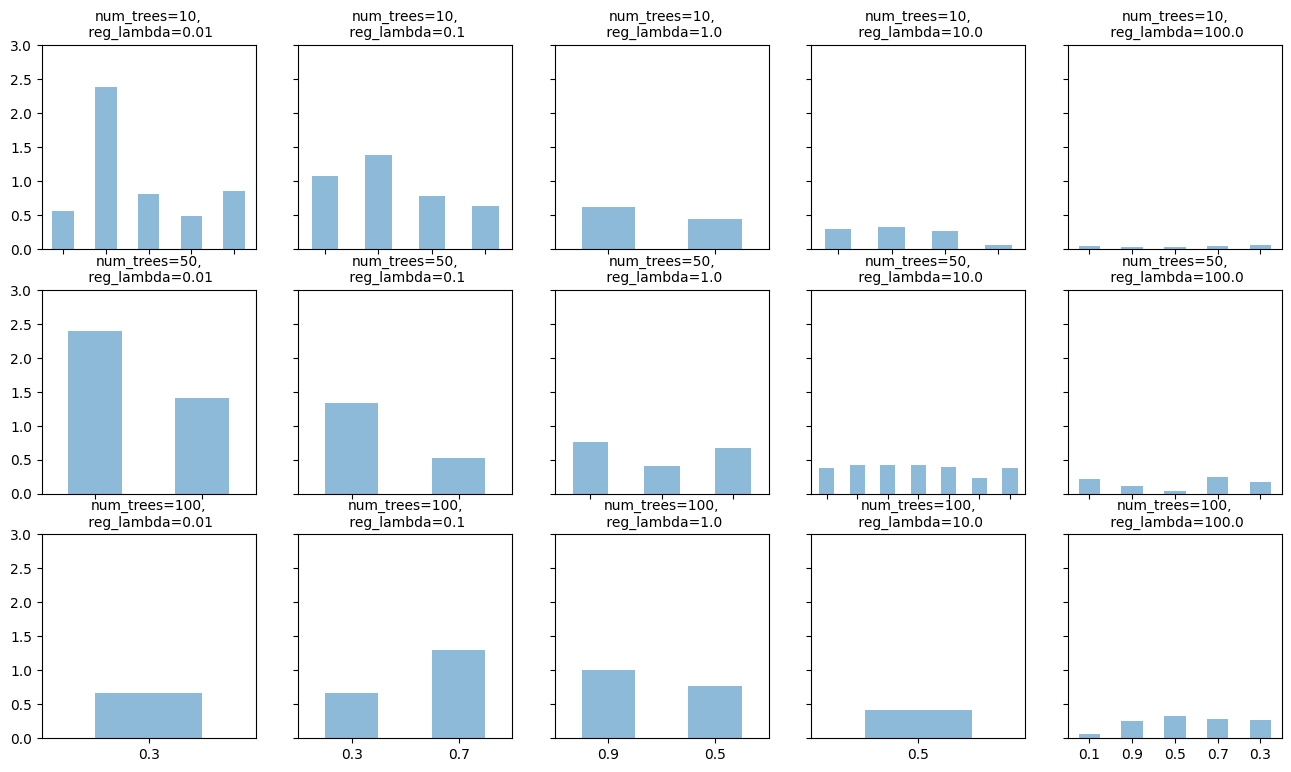

In [19]:
res_df = pd.DataFrame(cv_results, 
                      columns = ["param_n_estimators","param_learning_rate","param_reg_lambda","mean_test_score"])
# Note, MAE is made negative in the scikit-learn library so that it can be maximized. 
# As such, we can ignore the sign and assume all errors are positive.
res_df['mean_test_score']=-res_df['mean_test_score'].values

fig, axes = plt.subplots(figsize=(16, 9),nrows=3, ncols=5)
ax_all = plt.gca()

cnt = 0
for param, tmp in res_df.groupby(["param_n_estimators", "param_reg_lambda"]):
    ax = axes[cnt//5][cnt%5] # get the ax
    np.round(tmp[["param_learning_rate","mean_test_score"]],2).plot.bar(ax=ax, x="param_learning_rate", y="mean_test_score",
                                            alpha=0.5,legend=None)
    ax.set_xlabel("") # no xlabel
    ax.set_ylim(0, 3) # set y range
    # adjust xtick labels / adjust ytick labels
    if cnt//5 < 2:
        ax.xaxis.set_ticklabels("")
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(0);
    if cnt%5 > 0:
        ax.yaxis.set_ticklabels("")
    # set title
    ax.set_title(f"num_trees={param[0]},\n reg_lambda={param[1]}",fontsize=10);
    # update
    cnt =cnt+1

## <span style='color:#7F8BC7'> Backtesting  </span> 

There are in fact two scales at which backtesting can operate, depending on whether the forecasting model is dynamic (updated at each rebalancing) or fixed.

The first option: the aim is to build a unique model and test it on different time periods. Usually, it makes sense to test the model on successive dates, moving forward posterior to the training. This is what makes more sense, as it replicates what would happen in a live situation.

A popular approach is to split the data into $K$ partitions and to test $K$ different models: each one is tested on one of the partitions but trained on the $K − 1$ others. This is called **cross-validation** (CV). Some advocate one particular form of CV that aims at making sure that there is no informational overlap between the training and testing set. The premise is that if the structure of the cross-section of returns is constant through time, then training on future points and testing on past data is not problematic as long as there is no overlap.

The second major option is when the model is updated (retrained) at each rebalancing. The underlying idea here is that the structure of returns evolves through time and a dynamic model will capture the most recent trends. The drawback is that validation must/should be rerun at each rebalancing date.

The dimensions of backtesting are:
- number of strategies: possibly dozens or hundreds, or even more;
- number of trading dates: hundreds for monthly rebalancing;
- number of assets: hundreds or thousands;
- number of features: dozens or hundreds.

In order to train, test and tune hyperparameters for each model at many dates we need unrealistic amounts of computation power.

One solution is to keep an early portion of the training data and to perform a smaller scale validation on this subsample. Hyperparameters are tested on a limited number of dates and most of the time, they exhibit stability: satisfactory parameters for one date are usually acceptable for the next one and the following one as well. Thus, the full backtest can be carried out with these values when updating the models at each period.